# Using the Google API to connect to Google Map in real times in order to undestand which are the busiest hours for restaurants,bars, stations, and other publices places, for various barrios in Barcelona


Google maps provides a section called Popularity times, which for a selected public place, gives an overview of 
when the specific public place is more or less busy (picture below)

The goal of the assignement is to extrapolate from Google Maps the popularity times for group of public places located in the same area/barrio, for then averaging up 
their popularity times per each hour of the day (and each day of the week), and come up with overview of when a certain area/barrio is more or less busy

The result would be a tool that can be used as a guidance to monitor the busyness of barrios, where by busyness in this context we do not
refer to traffic of people in the street, but to whether, on average, public places of a specific barrio are
   at their full, medium or low capacity at a specific hour of the day

IMPORTANT - to make the exercise faster, only a selected number of public places will be taken into account, and 
just a few Barrios

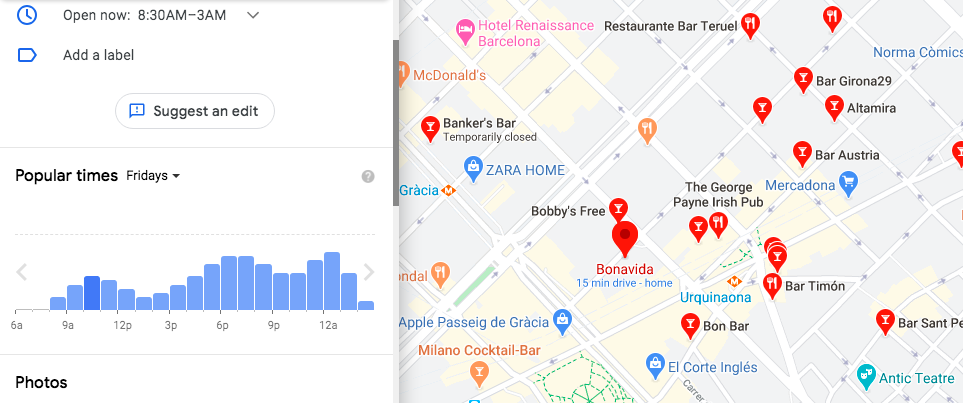

In [197]:
from IPython.display import Image
Image(filename='popularity.jpg.png', width=700, height=500)

Importing the required libraries and connecting to Google API

In [192]:
import gmaps
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import googlemaps
import pprint
import time
import geopandas as gpd

# Run codes to print popularity scores and define the necessary functions

We are creating a class with a seriese of function that allow one to easily interact with the Google Maps API and 
obtain information real time information in differet formats and in different pieces

In [41]:
import calendar
import datetime
import json
import logging
import math
import re
import ssl
import threading
import urllib.request
import urllib.parse
from time import sleep, time
from queue import Queue

import requests
from geopy import Point
from geopy.distance import vincenty, VincentyDistance

# urls for google api web service
BASE_URL = "https://maps.googleapis.com/maps/api/place/"
RADAR_URL = BASE_URL + "radarsearch/json?location={},{}&radius={}&types={}&key={}"
NEARBY_URL = BASE_URL + "nearbysearch/json?location={},{}&radius={}&types={}&key={}"
DETAIL_URL = BASE_URL + "details/json?placeid={}&key={}"

# user agent for populartimes request
USER_AGENT = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1) "
                            "AppleWebKit/537.36 (KHTML, like Gecko) "
                            "Chrome/54.0.2840.98 Safari/537.36"}


class PopulartimesException(Exception):
    """Exception raised for errors in the input.
    Attributes:
        expression -- input expression in which the error occurred
        message -- explanation of the error
    """

    def __init__(self, expression, message):
        self.expression = expression
        self.message = message


def rect_circle_collision(rect_left, rect_right, rect_bottom, rect_top, circle_x, circle_y, radius):
    # returns true iff circle intersects rectangle

    def clamp(val, min, max):
        # limits value to the range min..max
        if val < min:
            return min
        if val > max:
            return max
        return val

    # Find the closest point to the circle within the rectangle
    closest_x = clamp(circle_x, rect_left, rect_right);
    closest_y = clamp(circle_y, rect_bottom, rect_top);

    # Calculate the distance between the circle's center and this closest point
    dist_x = circle_x - closest_x;
    dist_y = circle_y - closest_y;

    # If the distance is less than the circle's radius, an intersection occurs
    dist_sq = (dist_x * dist_x) + (dist_y * dist_y);

    return dist_sq < (radius * radius);

def cover_rect_with_cicles(w, h, r):
    """
    fully cover a rectangle of given width and height with
    circles of radius r. This algorithm uses a hexagonal
    honeycomb pattern to cover the area.
    :param w: width of rectangle
    :param h: height of reclangle
    :param r: radius of circles
    :return: list of circle centers (x,y)
    """

    #initialize result list
    res = []

    # horizontal distance between circle centers
    x_dist = math.sqrt(3) * r
    # vertical distance between circle centers
    y_dist = 1.5 * r
    # number of circles per row (different for even/odd rows)
    cnt_x_even = math.ceil(w / x_dist)
    cnt_x_odd = math.ceil((w - x_dist/2) / x_dist) + 1
    # number of rows
    cnt_y = math.ceil((h-r) / y_dist) + 1

    y_offs = 0.5 * r
    for y in range(cnt_y):
        if y % 2 == 0:
            # shift even rows to the right
            x_offs = x_dist/2
            cnt_x = cnt_x_even
        else:
            x_offs = 0
            cnt_x = cnt_x_odd

        for x in range(cnt_x):
            res.append((x_offs + x*x_dist, y_offs + y*y_dist))

    # top-right circle is not always required
    if res and not rect_circle_collision(0, w, 0, h, res[-1][0], res[-1][1], r):
        res = res[0:-1]

    return res

def get_circle_centers(b1, b2, radius):
    """
    the function covers the area within the bounds with circles
    :param b1: south-west bounds [lat, lng]
    :param b2: north-east bounds [lat, lng]
    :param radius: specified radius, adapt for high density areas
    :return: list of circle centers that cover the area between lower/upper
    """

    sw = Point(b1)
    ne = Point(b2)

    # north/east distances
    dist_lat = vincenty(Point(sw[0], sw[1]), Point(ne[0], sw[1])).meters
    dist_lng = vincenty(Point(sw[0], sw[1]), Point(sw[0], ne[1])).meters

    circles = cover_rect_with_cicles(dist_lat, dist_lng, radius)
    cords = [
        VincentyDistance(meters=c[0])
        .destination(
            VincentyDistance(meters=c[1])
            .destination(point=sw, bearing=90),
            bearing=0
        )[:2]
        for c in circles
    ]

    return cords


def worker_radar():
    """
      worker that gets coordinates of queue and starts radar search
      :return:
      """
    while True:
        item = q_radar.get()
        get_radar(item)
        q_radar.task_done()


def get_radar(item):
    _lat, _lng = item["pos"]

    # places - nearby search
    # https://developers.google.com/places/web-service/search?hl=en#PlaceSearchRequests
    radar_str = NEARBY_URL.format(
        _lat, _lng, params["radius"], "|".join(params["type"]), params["API_key"]
    )

    # is this a next page request?
    if item["res"] > 0:
        # possibly wait remaining time until next_page_token becomes valid
        min_wait = 2  # wait at least 2 seconds before the next page request
        sec_passed = time() - item["last_req"]
        if sec_passed < min_wait:
            sleep(min_wait - sec_passed)
        radar_str += "&pagetoken=" + item["next_page_token"]

    resp = json.loads(requests.get(radar_str, auth=('user', 'pass')).text)
    check_response_code(resp)

    radar = resp["results"]

    item["res"] += len(radar)
    if item["res"] >= 60:
        logging.warning("Result limit in search radius reached, some data may get lost")

    bounds = params["bounds"]

    # retrieve google ids for detail search
    for place in radar:

        geo = place["geometry"]["location"]
        if bounds["lower"]["lat"] <= geo["lat"] <= bounds["upper"]["lat"] \
                and bounds["lower"]["lng"] <= geo["lng"] <= bounds["upper"]["lng"]:
            # this isn't thread safe, but we don't really care,
            # since in worst case a set entry is simply overwritten
            g_places[place["place_id"]] = place

    # if there are more results, schedule next page requests
    if "next_page_token" in resp:
        item["next_page_token"] = resp["next_page_token"]
        item["last_req"] = time()
        q_radar.put(item)


def worker_detail():
    """
    worker that gets item of queue and starts detailed data retrieval
    :return:
    """
    while True:
        item = q_detail.get()
        get_detail(item)
        q_detail.task_done()


def get_popularity_for_day(popularity):
    """
    Returns popularity for day
    :param popularity:
    :return:
    """

    # Initialize empty matrix with 0s
    pop_json = [[0 for _ in range(24)] for _ in range(7)]
    wait_json = [[0 for _ in range(24)] for _ in range(7)]

    for day in popularity:

        day_no, pop_times = day[:2]

        if pop_times:
            for hour_info in pop_times:

                hour = hour_info[0]
                pop_json[day_no - 1][hour] = hour_info[1]

                # check if the waiting string is available and convert no minutes
                if len(hour_info) > 5:
                    wait_digits = re.findall(r'\d+', hour_info[3])

                    if len(wait_digits) == 0:
                        wait_json[day_no - 1][hour] = 0
                    elif "min" in hour_info[3]:
                        wait_json[day_no - 1][hour] = int(wait_digits[0])
                    elif "hour" in hour_info[3]:
                        wait_json[day_no - 1][hour] = int(wait_digits[0]) * 60
                    else:
                        wait_json[day_no - 1][hour] = int(wait_digits[0]) * 60 + int(wait_digits[1])

                # day wrap
                if hour_info[0] == 23:
                    day_no = day_no % 7 + 1

    ret_popularity = [
        {
            "name": list(calendar.day_name)[d],
            "data": pop_json[d]
        } for d in range(7)
    ]

    # waiting time only if applicable
    ret_wait = [
        {
            "name": list(calendar.day_name)[d],
            "data": wait_json[d]
        } for d in range(7)
    ] if any(any(day) for day in wait_json) else []

    # {"name" : "monday", "data": [...]} for each weekday as list
    return ret_popularity, ret_wait


def index_get(array, *argv):
    """
    checks if a index is available in the array and returns it
    :param array: the data array
    :param argv: index integers
    :return: None if not available or the return value
    """

    try:

        for index in argv:
            array = array[index]

        return array

    # there is either no info available or no popular times
    # TypeError: rating/rating_n/populartimes wrong of not available
    except (IndexError, TypeError):
        return None


def add_optional_parameters(detail_json, detail, rating, rating_n, popularity, current_popularity, time_spent):
    """
    check for optional return parameters and add them to the result json
    :param detail_json:
    :param detail:
    :param rating:
    :param rating_n:
    :param popularity:
    :param current_popularity:
    :param time_spent:
    :return:
    """

    if rating:
        detail_json["rating"] = rating
    elif "rating" in detail:
        detail_json["rating"] = detail["rating"]

    if rating_n:
        detail_json["rating_n"] = rating_n

    if "international_phone_number" in detail:
        detail_json["international_phone_number"] = detail["international_phone_number"]

    if current_popularity:
        detail_json["current_popularity"] = current_popularity

    if popularity:
        popularity, wait_times = get_popularity_for_day(popularity)

        detail_json["populartimes"] = popularity

        if wait_times:
            detail_json["time_wait"] = wait_times

    if time_spent:
        detail_json["time_spent"] = time_spent

    return detail_json


def get_populartimes_from_search(place_identifier):
    """
    request information for a place and parse current popularity
    :param place_identifier: name and address string
    :return:
    """
    params_url = {
        "tbm": "map",
        "tch": 1,
        "hl": "en",
        "q": urllib.parse.quote_plus(place_identifier),
        "pb": "!4m12!1m3!1d4005.9771522653964!2d-122.42072974863942!3d37.8077459796541!2m3!1f0!2f0!3f0!3m2!1i1125!2i976"
              "!4f13.1!7i20!10b1!12m6!2m3!5m1!6e2!20e3!10b1!16b1!19m3!2m2!1i392!2i106!20m61!2m2!1i203!2i100!3m2!2i4!5b1"
              "!6m6!1m2!1i86!2i86!1m2!1i408!2i200!7m46!1m3!1e1!2b0!3e3!1m3!1e2!2b1!3e2!1m3!1e2!2b0!3e3!1m3!1e3!2b0!3e3!"
              "1m3!1e4!2b0!3e3!1m3!1e8!2b0!3e3!1m3!1e3!2b1!3e2!1m3!1e9!2b1!3e2!1m3!1e10!2b0!3e3!1m3!1e10!2b1!3e2!1m3!1e"
              "10!2b0!3e4!2b1!4b1!9b0!22m6!1sa9fVWea_MsX8adX8j8AE%3A1!2zMWk6Mix0OjExODg3LGU6MSxwOmE5ZlZXZWFfTXNYOGFkWDh"
              "qOEFFOjE!7e81!12e3!17sa9fVWea_MsX8adX8j8AE%3A564!18e15!24m15!2b1!5m4!2b1!3b1!5b1!6b1!10m1!8e3!17b1!24b1!"
              "25b1!26b1!30m1!2b1!36b1!26m3!2m2!1i80!2i92!30m28!1m6!1m2!1i0!2i0!2m2!1i458!2i976!1m6!1m2!1i1075!2i0!2m2!"
              "1i1125!2i976!1m6!1m2!1i0!2i0!2m2!1i1125!2i20!1m6!1m2!1i0!2i956!2m2!1i1125!2i976!37m1!1e81!42b1!47m0!49m1"
              "!3b1"
    }

    search_url = "https://www.google.de/search?" + "&".join(k + "=" + str(v) for k, v in params_url.items())
    logging.info("searchterm: " + search_url)

    # noinspection PyUnresolvedReferences
    gcontext = ssl.SSLContext(ssl.PROTOCOL_TLSv1)

    resp = urllib.request.urlopen(urllib.request.Request(url=search_url, data=None, headers=USER_AGENT),
                                  context=gcontext)
    data = resp.read().decode('utf-8').split('/*""*/')[0]

    # find eof json
    jend = data.rfind("}")
    if jend >= 0:
        data = data[:jend + 1]

    jdata = json.loads(data)["d"]
    jdata = json.loads(jdata[4:])

    # get info from result array, has to be adapted if backend api changes
    info = index_get(jdata, 0, 1, 0, 14)

    rating = index_get(info, 4, 7)
    rating_n = index_get(info, 4, 8)

    popular_times = index_get(info, 84, 0)

    # current_popularity is also not available if popular_times isn't
    current_popularity = index_get(info, 84, 7, 1)

    time_spent = index_get(info, 117, 0)

    # extract wait times and convert to minutes
    if time_spent:

        nums = [float(f) for f in re.findall(r'\d*\.\d+|\d+', time_spent.replace(",", "."))]
        contains_min, contains_hour = "min" in time_spent, "hour" in time_spent or "hr" in time_spent

        time_spent = None

        if contains_min and contains_hour:
            time_spent = [nums[0], nums[1] * 60]
        elif contains_hour:
            time_spent = [nums[0] * 60, (nums[0] if len(nums) == 1 else nums[1]) * 60]
        elif contains_min:
            time_spent = [nums[0], nums[0] if len(nums) == 1 else nums[1]]

        time_spent = [int(t) for t in time_spent]

    return rating, rating_n, popular_times, current_popularity, time_spent


def get_detail(place_id):
    """
    loads data for a given area
    :return:
    """
    global results

    # detail_json = get_populartimes(params["API_key"], place_id)
    detail_json = get_populartimes_by_detail(params["API_key"], g_places[place_id])

    if params["all_places"] or "populartimes" in detail_json:
        results.append(detail_json)


def get_populartimes(api_key, place_id):
    """
    sends request to detail to get a search string
    and uses standard proto buffer to get additional information
    on the current status of popular times
    :return: json details
    """

    # places api - detail search
    # https://developers.google.com/places/web-service/details?hl=de
    detail_str = DETAIL_URL.format(place_id, api_key)
    resp = json.loads(requests.get(detail_str, auth=('user', 'pass')).text)
    check_response_code(resp)
    detail = resp["result"]

    return get_populartimes_by_detail(api_key, detail)


def get_populartimes_by_detail(api_key, detail):
    address = detail["formatted_address"] if "formatted_address" in detail else detail.get("vicinity", "")

    place_identifier = "{} {}".format(detail["name"], address)

    detail_json = {
        "id": detail["place_id"],
        "name": detail["name"],
        "address": address,
        "types": detail["types"],
        "coordinates": detail["geometry"]["location"]
    }

    detail_json = add_optional_parameters(detail_json, detail, *get_populartimes_from_search(place_identifier))

    return detail_json


def check_response_code(resp):
    """
    check if query quota has been surpassed or other errors occured
    :param resp: json response
    :return:
    """
    if resp["status"] == "OK" or resp["status"] == "ZERO_RESULTS":
        return

    if resp["status"] == "REQUEST_DENIED":
        raise PopulartimesException("Google Places " + resp["status"],
                                    "Request was denied, the API key is invalid.")

    if resp["status"] == "OVER_QUERY_LIMIT":
        raise PopulartimesException("Google Places " + resp["status"],
                                    "You exceeded your Query Limit for Google Places API Web Service, "
                                    "check https://developers.google.com/places/web-service/usage "
                                    "to upgrade your quota.")

    if resp["status"] == "INVALID_REQUEST":
        raise PopulartimesException("Google Places " + resp["status"],
                                    "The query string is malformed, "
                                    "check if your formatting for lat/lng and radius is correct.")

    if resp["status"] == "INVALID_REQUEST":
        raise PopulartimesException("Google Places " + resp["status"],
                                    "The query string is malformed, "
                                    "check if your formatting for lat/lng and radius is correct.")

    if resp["status"] == "NOT_FOUND":
        raise PopulartimesException("Google Places " + resp["status"],
                                    "The place ID was not found and either does not exist or was retired.")

    raise PopulartimesException("Google Places " + resp["status"],
                                "Unidentified error with the Places API, please check the response code")


def run(_params):
    """
    wrap execution logic in method, for later external call
    :return:
    """
    global params, g_places, q_radar, q_detail, results

    start = datetime.datetime.now()

    # shared variables
    params = _params
    q_radar, q_detail = Queue(), Queue()
    g_places, results = dict(), list()

    logging.info("Adding places to queue...")

    # threading for radar search
    for i in range(params["n_threads"]):
        t = threading.Thread(target=worker_radar)
        t.daemon = True
        t.start()

    # cover search area with circles
    bounds = params["bounds"]
    for lat, lng in get_circle_centers([bounds["lower"]["lat"], bounds["lower"]["lng"]],  # southwest
                                       [bounds["upper"]["lat"], bounds["upper"]["lng"]],  # northeast
                                       params["radius"]):
        q_radar.put(dict(pos=(lat, lng), res=0))

    q_radar.join()
    logging.info("Finished in: {}".format(str(datetime.datetime.now() - start)))

    logging.info("{} places to process...".format(len(g_places)))

    # threading for detail search and popular times
    for i in range(params["n_threads"]):
        t = threading.Thread(target=worker_detail)
        t.daemon = True
        t.start()

    for g_place_id in g_places:
        q_detail.put(g_place_id)

    q_detail.join()
    logging.info("Finished in: {}".format(str(datetime.datetime.now() - start)))

    return results

Create a dictionary with include days of the week and hour of the day. 

This dictionnaire will be use to create a column in the final dataframe per each hour of each day of the week, 
and accordingly assign the a google popularity time level to each public venue that will be used in the 
analysis

In [42]:
dict_={'Monday_0':0, 'Tuesday_0':0, 'Wednesday_0':0, 'Thursday_0':0, 'Friday_0':0,'Saturday_0':0, 'Sunday_0':0,
       'Monday_1':0, 'Tuesday_1':0, 'Wednesday_1':0,'Thursday_1':0, 'Friday_1':0,'Saturday_1':0, 'Sunday_1':0,
       'Monday_2':0, 'Tuesday_2':0, 'Wednesday_2':0,'Thursday_2':0, 'Friday_2':0,'Saturday_2':0, 'Sunday_2':0,
       'Monday_3':0, 'Tuesday_3':0, 'Wednesday_3':0,'Thursday_3':0, 'Friday_3':0,'Saturday_3':0, 'Sunday_3':0,
       'Monday_4':0, 'Tuesday_4':0, 'Wednesday_4':0,'Thursday_4':0, 'Friday_4':0,'Saturday_4':0, 'Sunday_4':0,
       'Monday_5':0, 'Tuesday_5':0, 'Wednesday_5':0,'Thursday_5':0, 'Friday_5':0,'Saturday_5':0, 'Sunday_5':0,
       'Monday_6':0, 'Tuesday_6':0, 'Wednesday_6':0,'Thursday_6':0, 'Friday_6':0,'Saturday_6':0, 'Sunday_6':0,
       'Monday_7':0, 'Tuesday_7':0, 'Wednesday_7':0,'Thursday_7':0, 'Friday_7':0,'Saturday_7':0, 'Sunday_7':0,
       'Monday_8':0, 'Tuesday_8':0, 'Wednesday_8':0,'Thursday_8':0, 'Friday_8':0,'Saturday_8':0, 'Sunday_8':0,
       'Monday_9':0, 'Tuesday_9':0, 'Wednesday_9':0,'Thursday_9':0, 'Friday_9':0,'Saturday_9':0, 'Sunday_9':0,
       'Monday_10':0, 'Tuesday_10':0, 'Wednesday_10':0,'Thursday_10':0, 'Friday_10':0,'Saturday_10':0, 'Sunday_10':0,
       'Monday_11':0, 'Tuesday_11':0, 'Wednesday_11':0,'Thursday_11':0, 'Friday_11':0,'Saturday_11':0, 'Sunday_11':0,
       'Monday_12':0, 'Tuesday_12':0, 'Wednesday_12':0,'Thursday_12':0, 'Friday_12':0,'Saturday_12':0, 'Sunday_12':0,
       'Monday_13':0, 'Tuesday_13':0, 'Wednesday_13':0,'Thursday_13':0, 'Friday_13':0,'Saturday_13':0, 'Sunday_13':0,
       'Monday_14':0, 'Tuesday_14':0, 'Wednesday_14':0,'Thursday_14':0, 'Friday_14':0,'Saturday_14':0, 'Sunday_14':0,
       'Monday_15':0, 'Tuesday_15':0, 'Wednesday_15':0,'Thursday_15':0, 'Friday_15':0,'Saturday_15':0, 'Sunday_15':0,
       'Monday_16':0, 'Tuesday_16':0, 'Wednesday_16':0,'Thursday_16':0, 'Friday_16':0,'Saturday_16':0, 'Sunday_16':0,
       'Monday_17':0, 'Tuesday_17':0, 'Wednesday_17':0,'Thursday_17':0, 'Friday_17':0,'Saturday_17':0, 'Sunday_17':0,
       'Monday_18':0, 'Tuesday_18':0, 'Wednesday_18':0,'Thursday_18':0, 'Friday_18':0,'Saturday_18':0, 'Sunday_18':0,
       'Monday_19':0, 'Tuesday_19':0, 'Wednesday_19':0,'Thursday_19':0, 'Friday_19':0,'Saturday_19':0, 'Sunday_19':0,
       'Monday_20':0, 'Tuesday_20':0, 'Wednesday_20':0,'Thursday_20':0, 'Friday_20':0,'Saturday_20':0, 'Sunday_20':0,
       'Monday_21':0, 'Tuesday_21':0, 'Wednesday_21':0,'Thursday_21':0, 'Friday_21':0,'Saturday_21':0, 'Sunday_21':0,
       'Monday_22':0, 'Tuesday_22':0, 'Wednesday_22':0,'Thursday_22':0, 'Friday_22':0,'Saturday_22':0, 'Sunday_22':0,
       'Monday_23':0, 'Tuesday_23':0, 'Wednesday_23':0,'Thursday_23':0, 'Friday_23':0,'Saturday_23':0, 'Sunday_23':0}

In [44]:
columns=[]
for key, values in dict_.items():
    columns.append(key)

Creating two functions that allow us to interact with Google API using the API KEY

In [45]:
def getpopularitydataframe(API_KEY, PLACE_ID):
    popularity= get_populartimes(API_KEY, PLACE_ID)
    if 'populartimes' in popularity:
        dataframe=json_normalize(popularity['populartimes'])
        dataframe2= dataframe.data.apply(pd.Series)
        dataframe3=pd.concat([dataframe[['name']], dataframe2], axis=1)
        dataframe4 = dataframe3.reset_index().melt(id_vars = ['name'], value_vars = [c for c in dataframe3.columns if c != 'name'])
        dataframe4['dayhour'] = dataframe4['name'] + '_' + dataframe4['variable'].astype(str)
        dataframe4 = dataframe4[['dayhour','value']].set_index('dayhour').transpose()
    else:
        dataframe4=pd.DataFrame([dict_])
        
    return dataframe4  

In [46]:
def concatdataframe_popularity(DATAFRAME, API_KEY):
    
    dfs=[i for i in range(len(DATAFRAME['place_id']))]
    df=pd.DataFrame()
    for x in range(len(DATAFRAME['place_id'])):
        dfs[x]=getpopularitydataframe(API_KEY, DATAFRAME['place_id'][x])
        df=df.append([dfs[x]],ignore_index=True)
        df2=pd.concat([DATAFRAME,df], axis=1)
    return df2

# Import information per public place on the map and generate Dataframe

Creating a list of google maps keyworkds that are going to be used as to extrapolated list 
of public places in Barcelona

In [29]:
public_places=['cafe', 'art_gallery','bakery','bar','clothing_store','gym',
               'pharmacy', 'park', 'supermarket', 'shopping_mall','meal_delivery', 'meal_takeaway', 
              'beauty_salon', 'bicycle_store','book_store','bus_station', 'train_station','transit_station']

Defining the geographic coordinates for Barcelona to let google know which geographic areas we are considering
Specifically, we are telling Google to take into account the Barcelona centroids

In [30]:
barca_lat=41.397219
barca_long=2.190113
barcelona=f"{barca_lat},{barca_long}"

Connecting to Google maps API using the API key

In [35]:
dir(googlemaps.places)
gmaps = googlemaps.Client(key='MY PERSONAL API KEY')

Running a function to automatically extrapolate a list of public places (based on the keywords defined in the 
above list 'public_places') that are in the radious ot 2km from the centroid

In [49]:
jsons=[x for x in range(len(public_places))]
dataframes=[x for x in range(len(public_places))]
dfpopularities=[x for x in range(len(public_places))]
finaldfs=[x for x in range(len(public_places))]

listdataframes=[]
for p in range(len(public_places)):
    
    #get the json of containing the group of public places for the specified category
    jsons[p]=gmaps.places_nearby(location=barcelona,radius=2000,open_now=False, type=public_places[p])
    
    #get transoform the json in a datafrme using the specific
    dataframes[p]= json_normalize(jsons[p]['results'])
    
    #add popularity times to dataframe
    dfpopularities[p]=concatdataframe_popularity(dataframes[p],'MY PERSONAL API KEY')
    
    listdataframes.append(dfpopularities[p])    

In [348]:
firstcleanlist=[]
for df in listdataframes:
    if 'opening_hours.open_now' in df.columns:
        df=df.drop(['opening_hours.open_now'], axis=1)
        firstcleanlist.append(df)
    else:
        firstcleanlist.append(df)
        

In [349]:
secondcleanlist=[]
for df in firstcleanlist:
    if 'price_level' in df.columns:
        df=df.drop(['price_level'], axis=1)
        secondcleanlist.append(df)
    else:
        secondcleanlist.append(df)

In [350]:
final = pd.concat([df for df in secondcleanlist], sort=False)

In [351]:
final.shape

(332, 188)

The Final dataframe that we have obtained includes 332 public places in Barcelona, and each public place it is 
reported the level of busyness at each hour of the week on a scale between 0 and 100

We can now assing each public place to the right district/barrio using the geopoints available in the dataset and the polygons of Barcelona barrions avaiable in the Barcelona gejson

In [352]:
from shapely.geometry import Point, Polygon, MultiPolygon

cols=['name','geometry.location.lat','geometry.location.lng','vicinity']
for key, values in dict_.items():
    cols.append(key)

datafortableau=final.loc[:, final.columns.isin(cols)]

#reset index
datafortableau=datafortableau.reset_index(drop=True)


datafortableau[['geometry.location.lat','geometry.location.lng']]=datafortableau[[
    'geometry.location.lat','geometry.location.lng']].apply(lambda i: round_6_decimals(i))

#create a geodataframe with a 'geometry' column

geodf = gpd.GeoDataFrame(
    datafortableau, geometry=gpd.points_from_xy(datafortableau['geometry.location.lng'], 
                                                datafortableau['geometry.location.lat']))

#import polygons of BCN barrions from BCN geojson and create a dictionary with barrio name and polygon
districts=gpd.read_file('shapefiles_barcelona_distrito.geojson')
barrios_dict=dict(zip(districts['n_distri'], districts['geometry']))

#Assing public place in the datafrom to the correct barrio

geodf['bcnarea']='Unknown'
for key, values in barrios_dict.items():
    for j in range(len(geodf['geometry'])):
        if geodf['geometry'][j].within(values):
            geodf['bcnarea'][j]=key


/Users/gvaccar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [357]:
geodf.head(2)

,name,vicinity,geometry.location.lat,geometry.location.lng,Monday_0,Tuesday_0,Wednesday_0,Thursday_0,Friday_0,Saturday_0,...,Sunday_22,Monday_23,Tuesday_23,Wednesday_23,Thursday_23,Friday_23,Saturday_23,Sunday_23,geometry,bcnarea
0,Bar El Born,"Passeig del Born, 26, Barcelona",41.384718,2.182947,58,16,41,41,45,70,...,16,19,41,41,38,93,77,32,POINT (2.18295 41.38472),Ciutat Vella
1,Alsur Cafè (El Born),"Plaça de Sant Cugat, 1, Barcelona",41.386510,2.180039,0,0,0,0,0,0,...,25,0,0,0,0,0,0,0,POINT (2.18004 41.38651),Ciutat Vella


# The dataset is ready to be exported to Tabaeau for a nice Vislualization

In [354]:
geodf.to_csv('populartimes.csv')

Tableau Visualization

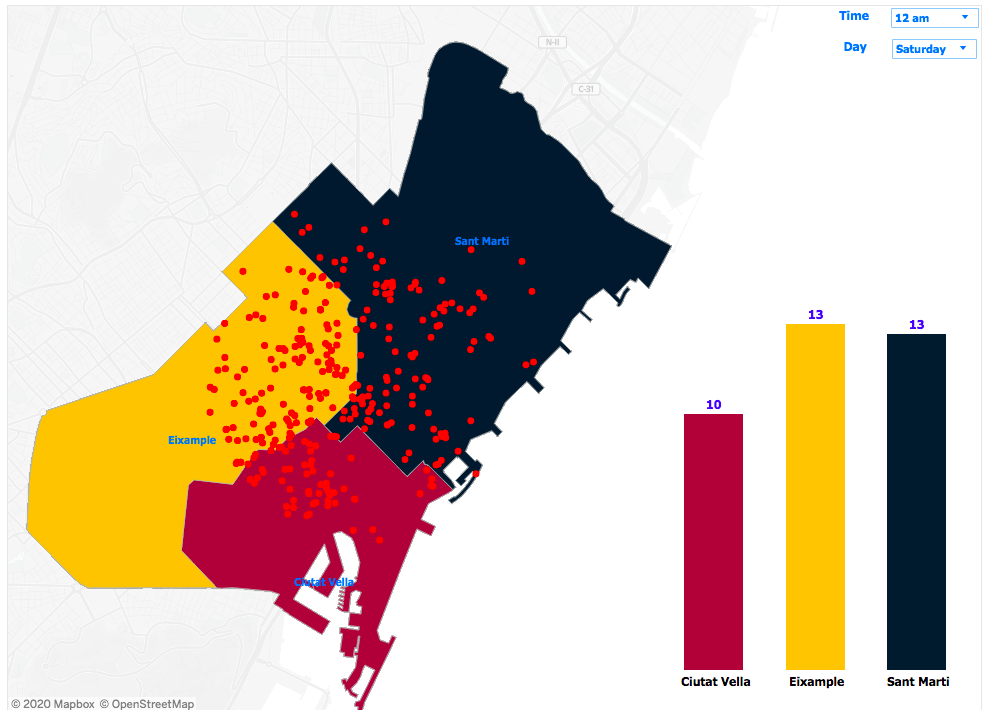

In [356]:
Image(filename='visualization.png', width=800, height=700)